# `AbsorptionModel` Tutorial

Trey V. Wenger (c) November 2024

Here we demonstrate the basic features of the `AbsorptionModel` model. `AbsorptionModel` models the 1612, 1665, 1667, and 1720 MHz hyperfine transitions of OH and predicts their absorption spectra: $1-\exp(-\tau)$.

In [1]:
# General imports    
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

import pytensor
print("pytensor version:", pytensor.__version__)

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import amoeba2
print("amoeba2 version:", amoeba2.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pytensor version: 2.26.3
pymc version: 5.18.2
bayes_spec version: 1.7.2
amoeba2 version: 1.0.1+7.gad490bf.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `AbsorptionModel`, but we must pack a "dummy" data structure first. The model expects the observations to be named `"absorption_1612", "absorption_1665", "absorption_1667", and "absorption_1720"`.

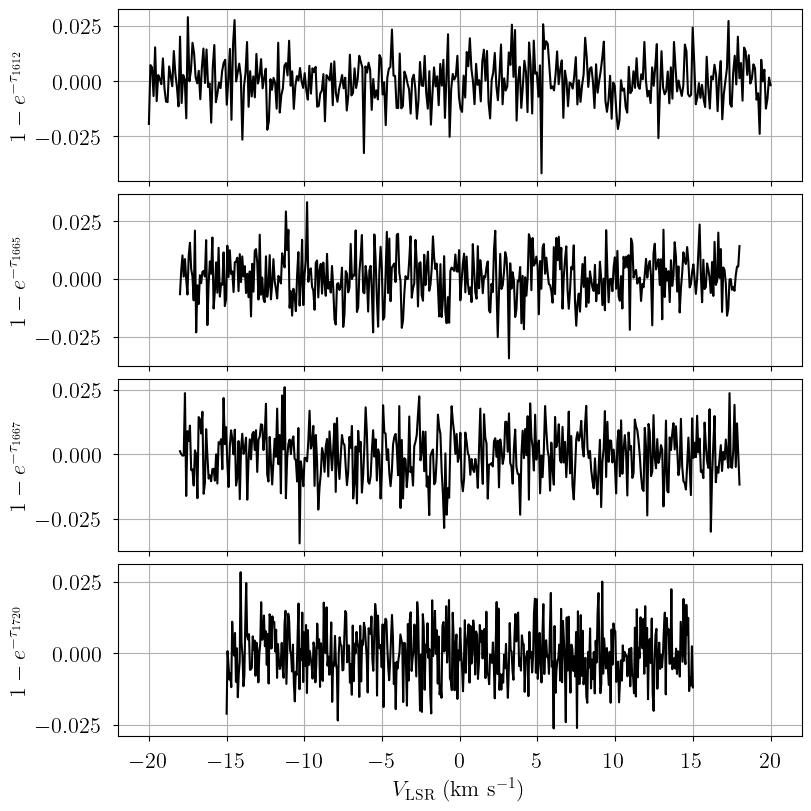

In [2]:
from bayes_spec import SpecData

# spectral axes definition
velo_axis = {
    "1612": np.linspace(-20.0, 20.0, 400), # km s-1
    "1665": np.linspace(-18.0, 18.0, 450),
    "1667": np.linspace(-18.0, 18.0, 450),
    "1720": np.linspace(-15.0, 15.0, 500),
}

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_absorption = {
    "1612": 0.01,
    "1665": 0.01,
    "1667": 0.01,
    "1720": 0.01,
}

# spectral data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
absorption = {label: rms_absorption[label] * np.random.randn(len(velo_axis[label])) for label in velo_axis.keys()}

# TauModel expects four observations
dummy_data = {
    f"absorption_{label}": SpecData(
        velo_axis[label],
        absorption[label],
        rms_absorption[label],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$1 - e^{-\tau_{"+f"{label}"+r"}}$"
    )
    for label in velo_axis.keys()
}

# Plot dummy data
fig, axes = plt.subplots(4, sharex=True, layout="constrained", figsize=(8, 8))
for ax, dummy_datum in zip(axes, dummy_data.values()):
    ax.plot(dummy_datum.spectral, dummy_datum.brightness, "k-")
    ax.set_ylabel(dummy_datum.ylabel)
_ = axes[-1].set_xlabel(dummy_datum.xlabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood.

In [3]:
from amoeba2 import AbsorptionModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = AbsorptionModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau = [0.1, 0.1], # mean and width of log10(tau) prior
    prior_log10_depth = [0.0, 0.25], # mean and width of log10(depth) prior (pc)
    prior_log10_Tkin = [2.0, 1.0], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_log10_nth_fwhm_1pc = [0.2, 0.1], # mean and width of non-thermal FWHM prior (km/s)
    prior_depth_nth_fwhm_power = [0.4, 0.1], # mean and width of non-thermal FWHM exponent prior
    ordered = False, # do not assume optically-thin
    mainline_pos_tau = True, # force main line optical depths to be positive
)
model.add_likelihood()

In [4]:
# Evaluate likelihood for given model parameters
sim_params = {
    "tau_1612": np.array([-0.05, 0.05, 0.05]),
    "tau_1665": np.array([0.05, 0.1, 0.02]),
    "tau_1667": np.array([0.02, 0.02, 0.1]),
    "log10_depth": np.array([0.0, 0.25, -0.25]),
    "log10_Tkin": np.array([1.25, 1.75, 1.0]),
    "velocity": np.array([-3.0, 1.0, 3.0]),
    "log10_nth_fwhm_1pc": 0.2,
    "depth_nth_fwhm_power": 0.3,
    "baseline_absorption_1612_norm": [0.0],
    "baseline_absorption_1665_norm": [0.0],
    "baseline_absorption_1667_norm": [0.0],
    "baseline_absorption_1720_norm": [0.0],
}

data = {}
for i, label in enumerate(velo_axis.keys()):
    sim_absorption = model.model[f"absorption_{label}"].eval(sim_params, on_unused_input="ignore")
    data[f"absorption_{label}"] = SpecData(
        velo_axis[label],
        sim_absorption,
        rms_absorption[label],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$1 - e^{-\tau_{"+f"{label}"+r"}}$"
    )

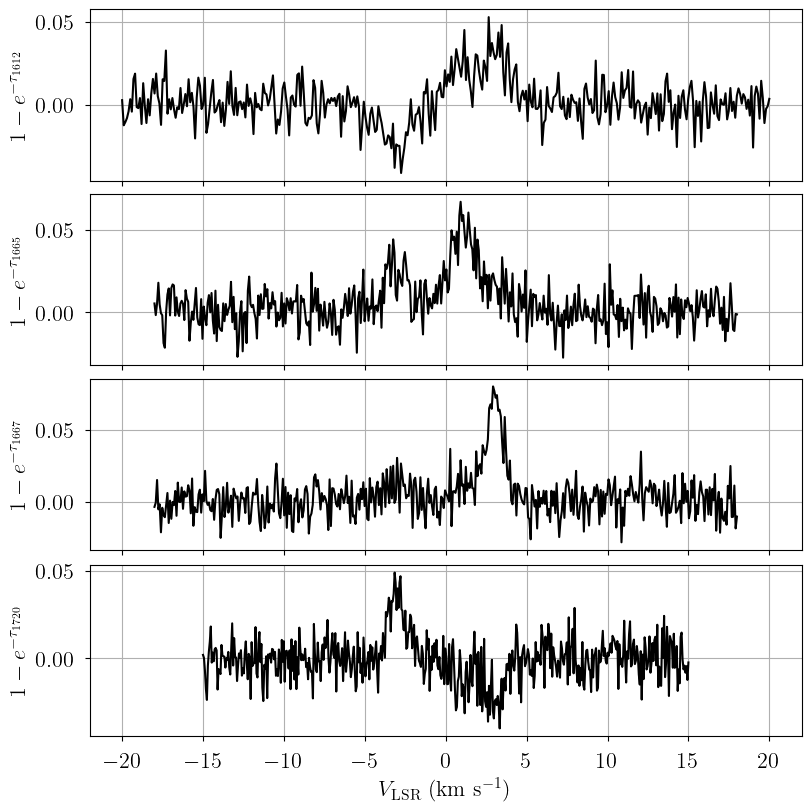

In [5]:
# Plot data
fig, axes = plt.subplots(4, sharex=True, layout="constrained", figsize=(8, 8))
for ax, datum in zip(axes, data.values()):
    ax.plot(datum.spectral, datum.brightness, "k-")
    ax.set_ylabel(datum.ylabel)
_ = axes[-1].set_xlabel(datum.xlabel)

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `TauModel`. Here we create a new model with the simulated data.

In [6]:
# Initialize and define the model
model = AbsorptionModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau = [0.1, 0.1], # mean and width of log10(tau) prior
    prior_log10_depth = [0.0, 0.25], # mean and width of log10(depth) prior (pc)
    prior_log10_Tkin = [2.0, 1.0], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_log10_nth_fwhm_1pc = [0.2, 0.1], # mean and width of non-thermal FWHM prior (km/s)
    prior_depth_nth_fwhm_power = [0.4, 0.1], # mean and width of non-thermal FWHM exponent prior
    ordered = False, # do not assume optically-thin
    mainline_pos_tau = True, # force main line optical depths to be positive
)
model.add_likelihood()

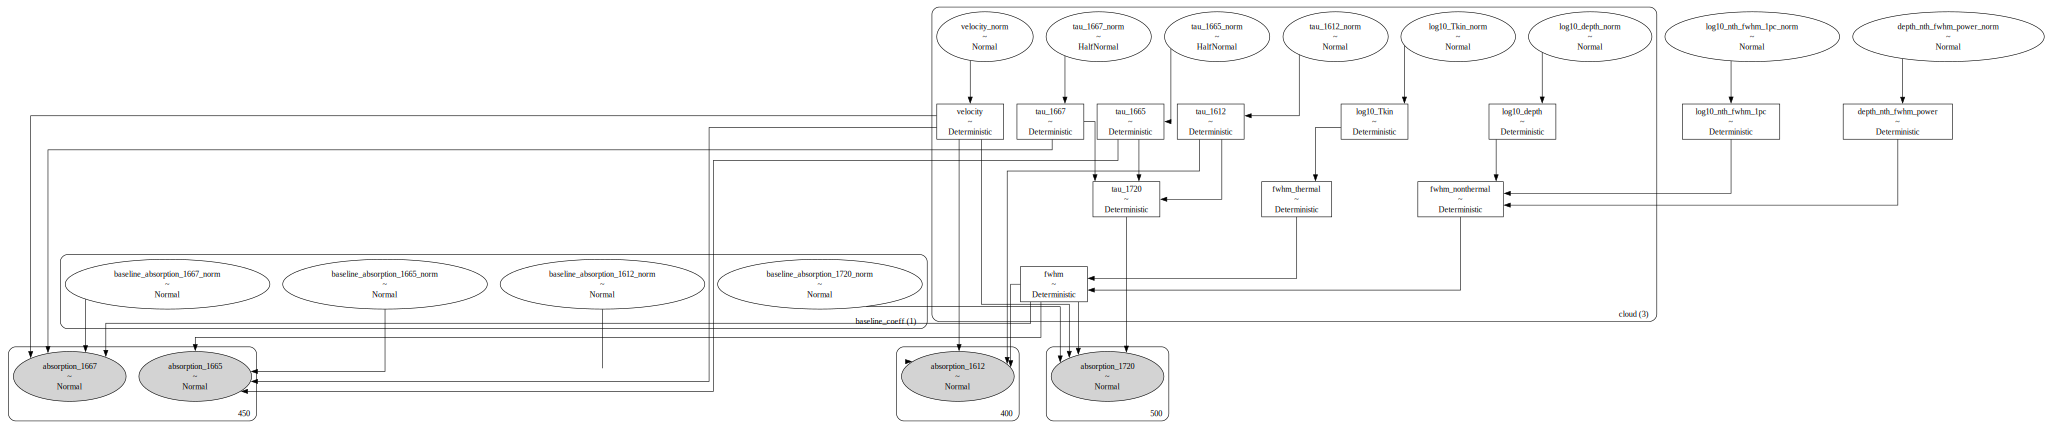

In [7]:
# Plot model graph
gviz = pymc.model_to_graphviz(model.model)
gviz.graph_attr["rankdir"] = "TB"
gviz.graph_attr["splines"] = "ortho"
# gviz.graph_attr["newrank"] = "true"
gviz.graph_attr["rank"] = "same"
gviz.graph_attr["ranksep"] = "1.0"
gviz.graph_attr["nodesep"] = "0.3"
gviz.render('absorption_model', format='png')
gviz

In [8]:
# model string representation
print(model.model.str_repr())

baseline_absorption_1612_norm ~ Normal(0, 1)
baseline_absorption_1665_norm ~ Normal(0, 1)
baseline_absorption_1667_norm ~ Normal(0, 1)
baseline_absorption_1720_norm ~ Normal(0, 1)
                tau_1612_norm ~ Normal(0, 1)
                tau_1665_norm ~ HalfNormal(0, 1)
                tau_1667_norm ~ HalfNormal(0, 1)
             log10_depth_norm ~ Normal(0, 1)
              log10_Tkin_norm ~ Normal(0, 1)
                velocity_norm ~ Normal(0, 1)
      log10_nth_fwhm_1pc_norm ~ Normal(0, 1)
    depth_nth_fwhm_power_norm ~ Normal(0, 1)
                     tau_1612 ~ Deterministic(f(tau_1612_norm))
                     tau_1665 ~ Deterministic(f(tau_1665_norm))
                     tau_1667 ~ Deterministic(f(tau_1667_norm))
                     tau_1720 ~ Deterministic(f(tau_1612_norm, tau_1667_norm, tau_1665_norm))
                  log10_depth ~ Deterministic(f(log10_depth_norm))
                   log10_Tkin ~ Deterministic(f(log10_Tkin_norm))
                     velocity ~ D

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [absorption_1612, absorption_1665, absorption_1667, absorption_1720, baseline_absorption_1612_norm, baseline_absorption_1665_norm, baseline_absorption_1667_norm, baseline_absorption_1720_norm, depth_nth_fwhm_power_norm, log10_Tkin_norm, log10_depth_norm, log10_nth_fwhm_1pc_norm, tau_1612_norm, tau_1665_norm, tau_1667_norm, velocity_norm]


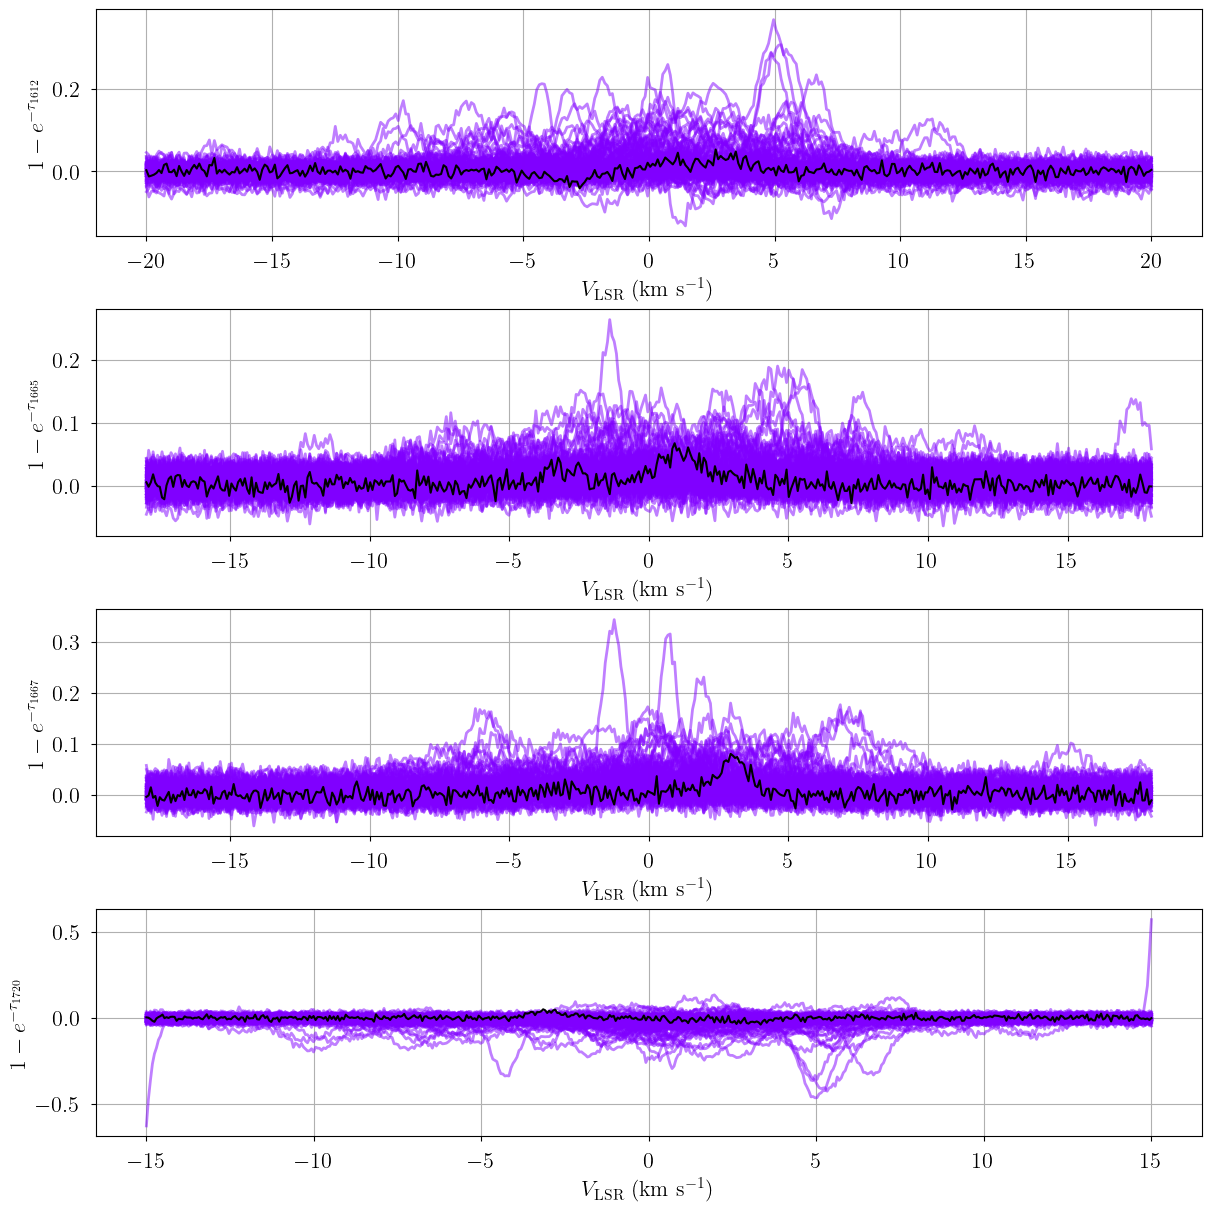

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
axes = plot_predictive(model.data, prior.prior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

We can also investigate the effect of our chosen priors on the deterministic quantities.

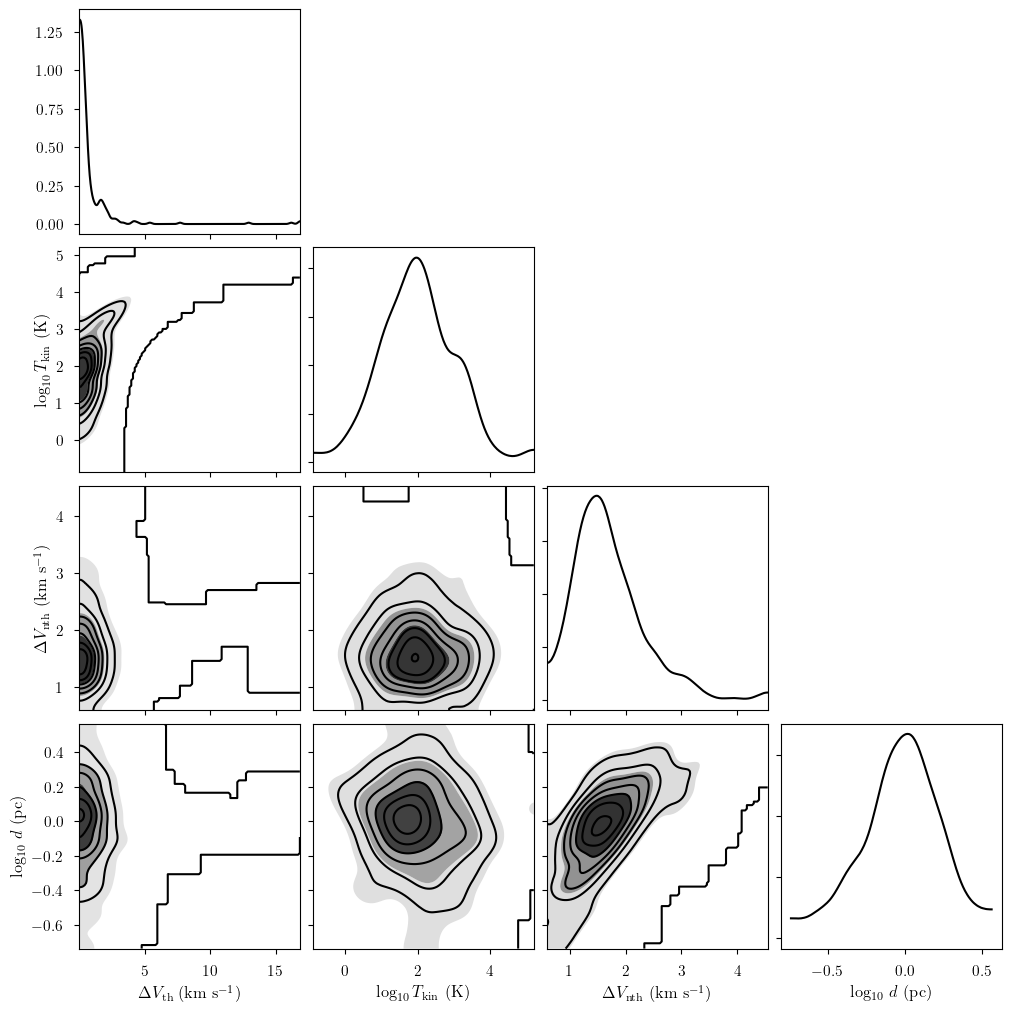

In [10]:
from bayes_spec.plots import plot_pair

var_names = ["fwhm_thermal", "log10_Tkin", "fwhm_nonthermal", "log10_depth"]
_ = plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [11]:
import time

start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 3300
Interrupted at 3,299 [3%]: Average Loss = -4,984.2


Output()

Runtime: 0.30 minutes


In [12]:
az.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
baseline_absorption_1612_norm[0] -0.087  0.041  -0.168   -0.011      0.001   
baseline_absorption_1665_norm[0] -0.302  0.034  -0.363   -0.238      0.001   
baseline_absorption_1667_norm[0] -0.252  0.033  -0.313   -0.194      0.001   
baseline_absorption_1720_norm[0]  0.008  0.040  -0.065    0.082      0.001   
tau_1612_norm[0]                 -0.538  0.036  -0.599   -0.467      0.001   
tau_1612_norm[1]                 -1.467  0.034  -1.525   -1.397      0.001   
tau_1612_norm[2]                 -0.473  0.031  -0.534   -0.419      0.001   
log10_depth_norm[0]               0.597  0.266   0.120    1.121      0.008   
log10_depth_norm[1]              -0.207  0.311  -0.759    0.370      0.010   
log10_depth_norm[2]              -0.801  0.230  -1.238   -0.379      0.007   
log10_Tkin_norm[0]               -0.297  0.666  -1.574    0.901      0.022   
log10_Tkin_norm[1]               -0.549  0.645  -1.697    0.691      0.019   
log10_Tkin_norm[2]               -0.630  0.685  -2.041    0.532      0.023   
velocity_norm[0]                  0.203  0.010   0.184    0.222      0.000   
velocity_norm[1]                 -0.604  0.011  -0.626   -0.585      0.000   
velocity_norm[2]                  0.616  0.007   0.603    0.630      0.000   
log10_nth_fwhm_1pc_norm          -0.162  0.149  -0.461    0.086      0.005   
depth_nth_fwhm_power_norm        -0.569  0.734  -2.139    0.641      0.024   
tau_1665_norm[0]                  1.026  0.051   0.940    1.126      0.002   
tau_1665_norm[1]                  0.450  0.046   0.359    0.529      0.002   
tau_1665_norm[2]                  0.219  0.045   0.146    0.308      0.002   
tau_1667_norm[0]                  0.220  0.055   0.123    0.318      0.002   
tau_1667_norm[1]                  0.227  0.048   0.148    0.323      0.002   
tau_1667_norm[2]                  1.036  0.048   0.941    1.126      0.002   
tau_1612[0]                       0.046  0.004   0.040    0.053      0.000   
tau_1612[1]                      -0.047  0.003  -0.052   -0.040      0.000   
tau_1612[2]                       0.053  0.003   0.047    0.058      0.000   
tau_1665[0]                       0.103  0.005   0.094    0.113      0.000   
tau_1665[1]                       0.045  0.005   0.036    0.053      0.000   
tau_1665[2]                       0.022  0.005   0.015    0.031      0.000   
tau_1667[0]                       0.022  0.005   0.012    0.032      0.000   
tau_1667[1]                       0.023  0.005   0.015    0.032      0.000   
tau_1667[2]                       0.104  0.005   0.094    0.113      0.000   
tau_1720[0]                      -0.023  0.004  -0.030   -0.016      0.000   
tau_1720[1]                       0.058  0.004   0.051    0.064      0.000   
tau_1720[2]                      -0.037  0.003  -0.043   -0.031      0.000   
log10_depth[0]                    0.149  0.066   0.030    0.280      0.002   
log10_depth[1]                   -0.052  0.078  -0.190    0.093      0.003   
log10_depth[2]                   -0.200  0.058  -0.310   -0.095      0.002   
log10_Tkin[0]                     1.703  0.666   0.426    2.901      0.022   
log10_Tkin[1]                     1.451  0.645   0.303    2.691      0.019   
log10_Tkin[2]                     1.370  0.685  -0.041    2.532      0.023   
velocity[0]                       1.017  0.051   0.922    1.111      0.002   
velocity[1]                      -3.022  0.056  -3.131   -2.923      0.002   
velocity[2]                       3.079  0.036   3.013    3.148      0.001   
log10_nth_fwhm_1pc                0.184  0.015   0.154    0.209      0.000   
depth_nth_fwhm_power              0.343  0.073   0.186    0.464      0.002   
fwhm_thermal[0]                   0.401  0.354   0.035    1.021      0.012   
fwhm_thermal[1]                   0.293  0.250   0.017    0.704      0.007   
fwhm_thermal[2]                   0.281  0.304   0.013    0.630      0.010   
fwhm_nonthermal[0]                1.722  0.118   1.514   

Sampling: [absorption_1612, absorption_1665, absorption_1667, absorption_1720]


Output()

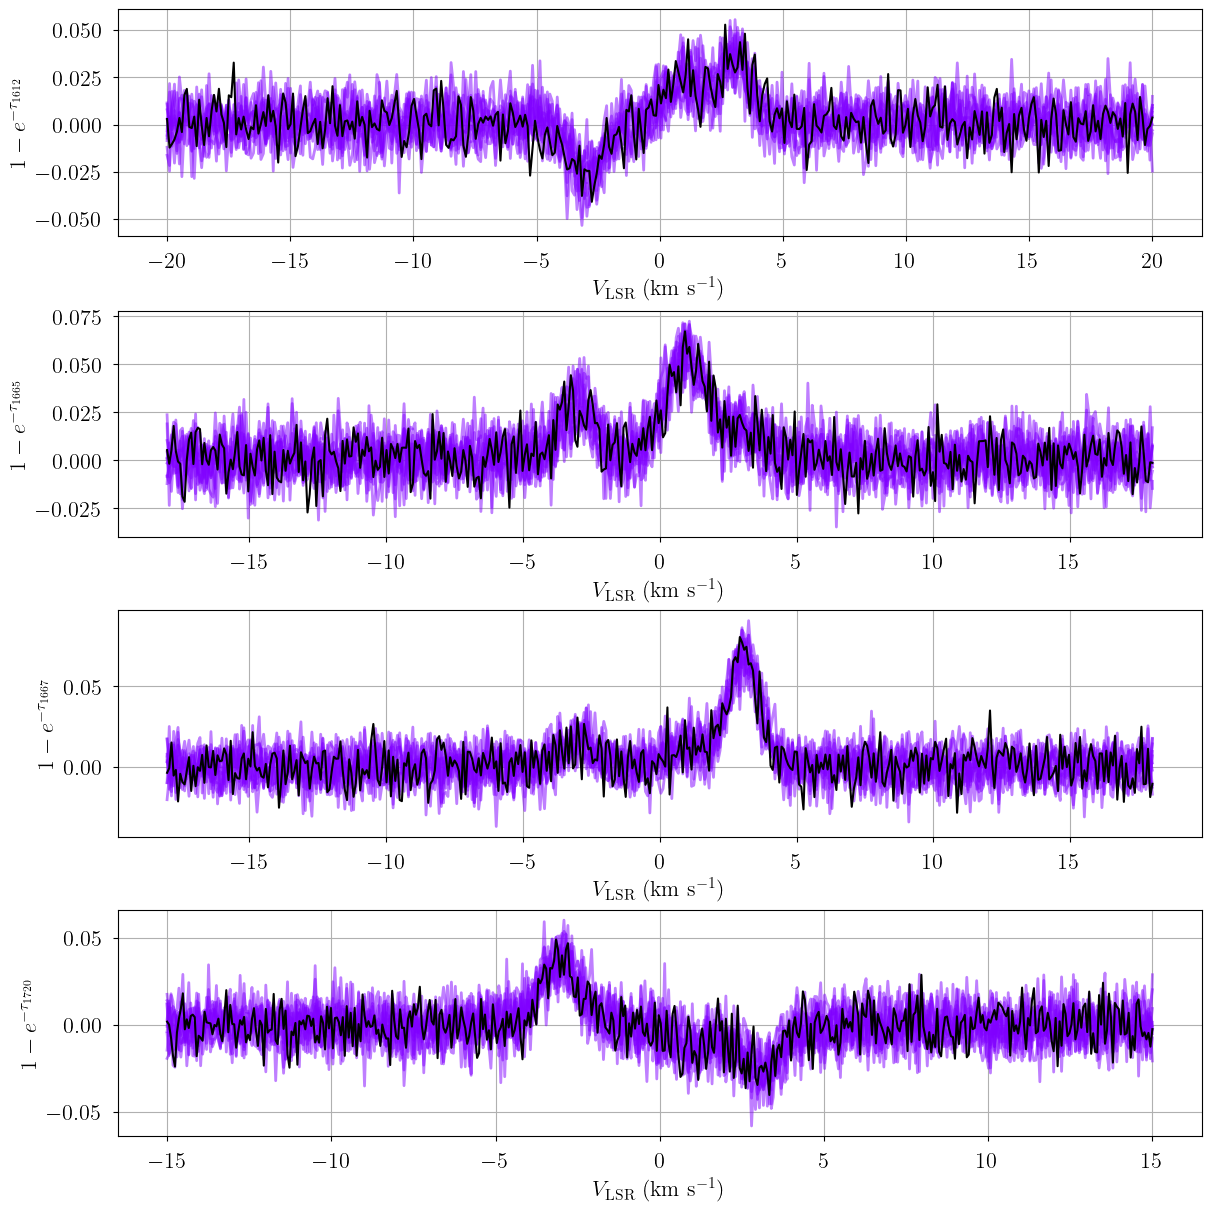

In [13]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [14]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3300
Interrupted at 3,299 [3%]: Average Loss = -4,984.2
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_absorption_1612_norm, baseline_absorption_1665_norm, baseline_absorption_1667_norm, baseline_absorption_1720_norm, tau_1612_norm, tau_1665_norm, tau_1667_norm, log10_depth_norm, log10_Tkin_norm, velocity_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.


Adding log-likelihood to trace


Output()

There were 1 divergences in converged chains.
Runtime: 1.37 minutes


In [15]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


Check that the effective sample sizes are large and the covergence statistic `r_hat` is close to 1! If not, you may have to increase the number of tuning steps (`tune=2000`) or the NUTS acceptance rate (`target_accept=0.9`).

In [16]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
baseline_absorption_1612_norm[0] -0.092  0.041  -0.173   -0.017      0.002   
baseline_absorption_1665_norm[0] -0.311  0.035  -0.376   -0.244      0.001   
baseline_absorption_1667_norm[0] -0.250  0.034  -0.321   -0.189      0.001   
baseline_absorption_1720_norm[0]  0.009  0.035  -0.054    0.080      0.001   
tau_1612_norm[0]                 -0.537  0.039  -0.607   -0.464      0.001   
tau_1612_norm[1]                 -1.456  0.035  -1.521   -1.393      0.001   
tau_1612_norm[2]                 -0.486  0.036  -0.548   -0.418      0.001   
log10_depth_norm[0]               0.478  0.773  -1.010    1.966      0.035   
log10_depth_norm[1]              -0.165  0.662  -1.428    1.066      0.020   
log10_depth_norm[2]              -0.648  0.626  -1.806    0.479      0.019   
log10_Tkin_norm[0]                0.096  0.817  -1.381    1.286      0.035   
log10_Tkin_norm[1]               -0.305  0.777  -1.705    0.891      0.025   
log10_Tkin_norm[2]               -0.443  0.719  -1.740    0.713      0.026   
velocity_norm[0]                  0.205  0.010   0.187    0.223      0.000   
velocity_norm[1]                 -0.607  0.008  -0.623   -0.592      0.000   
velocity_norm[2]                  0.611  0.006   0.600    0.621      0.000   
log10_nth_fwhm_1pc_norm          -0.449  0.607  -1.678    0.652      0.043   
depth_nth_fwhm_power_norm        -0.135  1.001  -2.066    1.640      0.045   
tau_1665_norm[0]                  1.038  0.064   0.914    1.154      0.001   
tau_1665_norm[1]                  0.441  0.047   0.355    0.528      0.001   
tau_1665_norm[2]                  0.212  0.048   0.128    0.305      0.002   
tau_1667_norm[0]                  0.221  0.054   0.111    0.317      0.002   
tau_1667_norm[1]                  0.217  0.046   0.134    0.303      0.001   
tau_1667_norm[2]                  1.016  0.055   0.912    1.117      0.002   
tau_1612[0]                       0.046  0.004   0.039    0.054      0.000   
tau_1612[1]                      -0.046  0.003  -0.052   -0.039      0.000   
tau_1612[2]                       0.051  0.004   0.045    0.058      0.000   
tau_1665[0]                       0.104  0.006   0.091    0.115      0.000   
tau_1665[1]                       0.044  0.005   0.035    0.053      0.000   
tau_1665[2]                       0.021  0.005   0.013    0.031      0.000   
tau_1667[0]                       0.022  0.005   0.011    0.032      0.000   
tau_1667[1]                       0.022  0.005   0.013    0.030      0.000   
tau_1667[2]                       0.102  0.006   0.091    0.112      0.000   
tau_1720[0]                      -0.023  0.004  -0.029   -0.017      0.000   
tau_1720[1]                       0.057  0.004   0.050    0.064      0.000   
tau_1720[2]                      -0.036  0.003  -0.042   -0.031      0.000   
log10_depth[0]                    0.120  0.193  -0.253    0.491      0.009   
log10_depth[1]                   -0.041  0.166  -0.357    0.267      0.005   
log10_depth[2]                   -0.162  0.157  -0.451    0.120      0.005   
log10_Tkin[0]                     2.096  0.817   0.619    3.286      0.035   
log10_Tkin[1]                     1.695  0.777   0.295    2.891      0.025   
log10_Tkin[2]                     1.557  0.719   0.260    2.713      0.026   
velocity[0]                       1.026  0.049   0.934    1.117      0.001   
velocity[1]                      -3.033  0.042  -3.117   -2.959      0.001   
velocity[2]                       3.055  0.028   2.999    3.105      0.001   
log10_nth_fwhm_1pc                0.155  0.061   0.032    0.265      0.004   
depth_nth_fwhm_power              0.386  0.100   0.193    0.564      0.004   
fwhm_thermal[0]                   0.664  0.473   0.020    1.496      0.035   
fwhm_thermal[1]                   0.409  0.298   0.023    0.990      0.013   
fwhm_thermal[2]                   0.336  0.234   0.021    0.794      0.014   
fwhm_nonthermal[0]                1.602  0.265   1.008   

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [absorption_1612, absorption_1665, absorption_1667, absorption_1720]


Output()

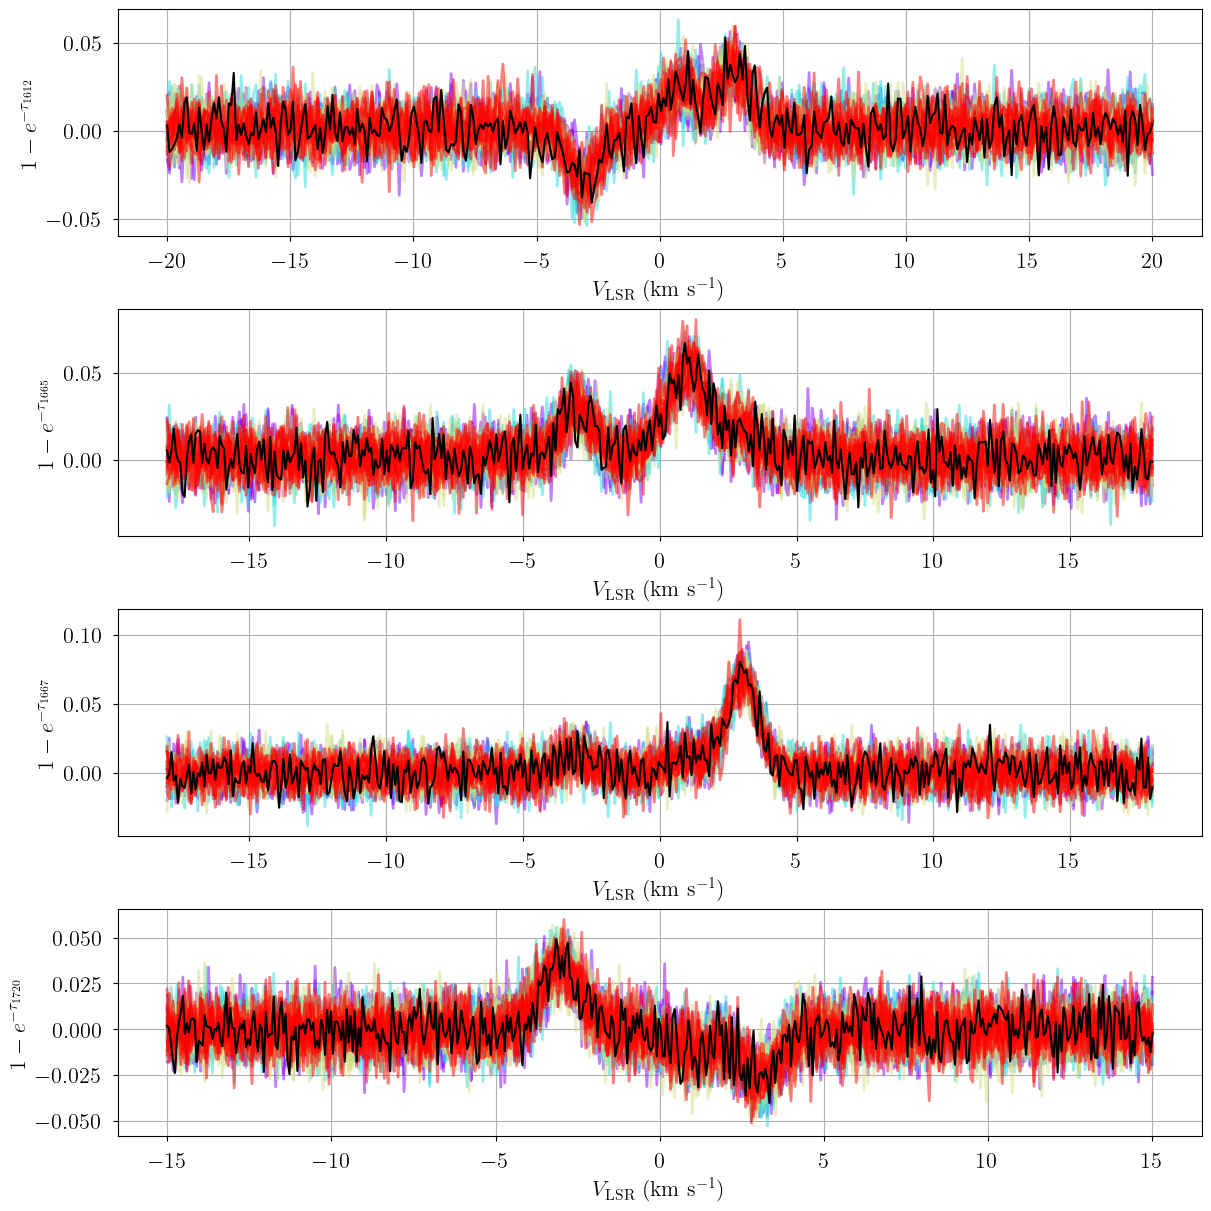

In [17]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

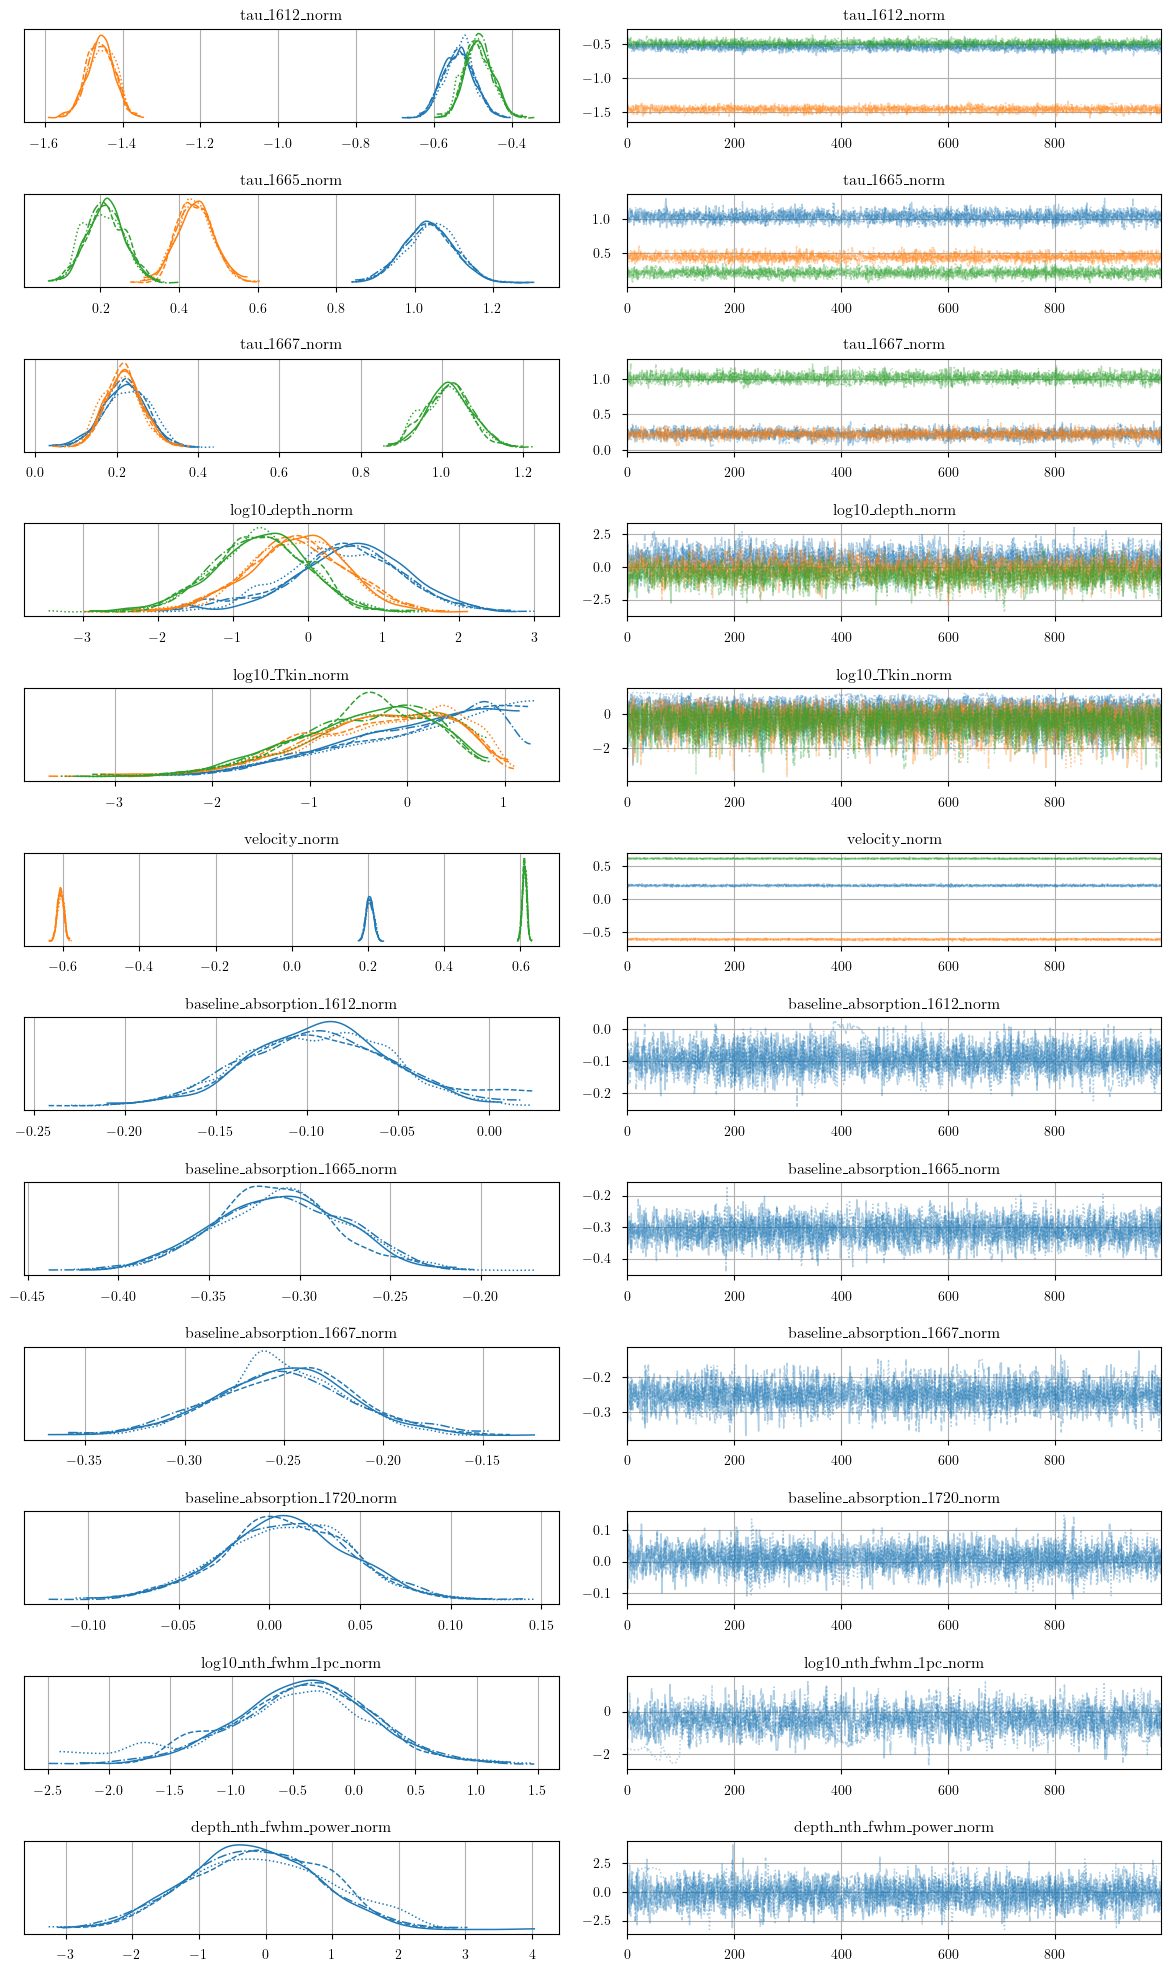

In [18]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
axes.ravel()[0].figure.set_size_inches(12, 20)
axes.ravel()[0].figure.tight_layout()

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

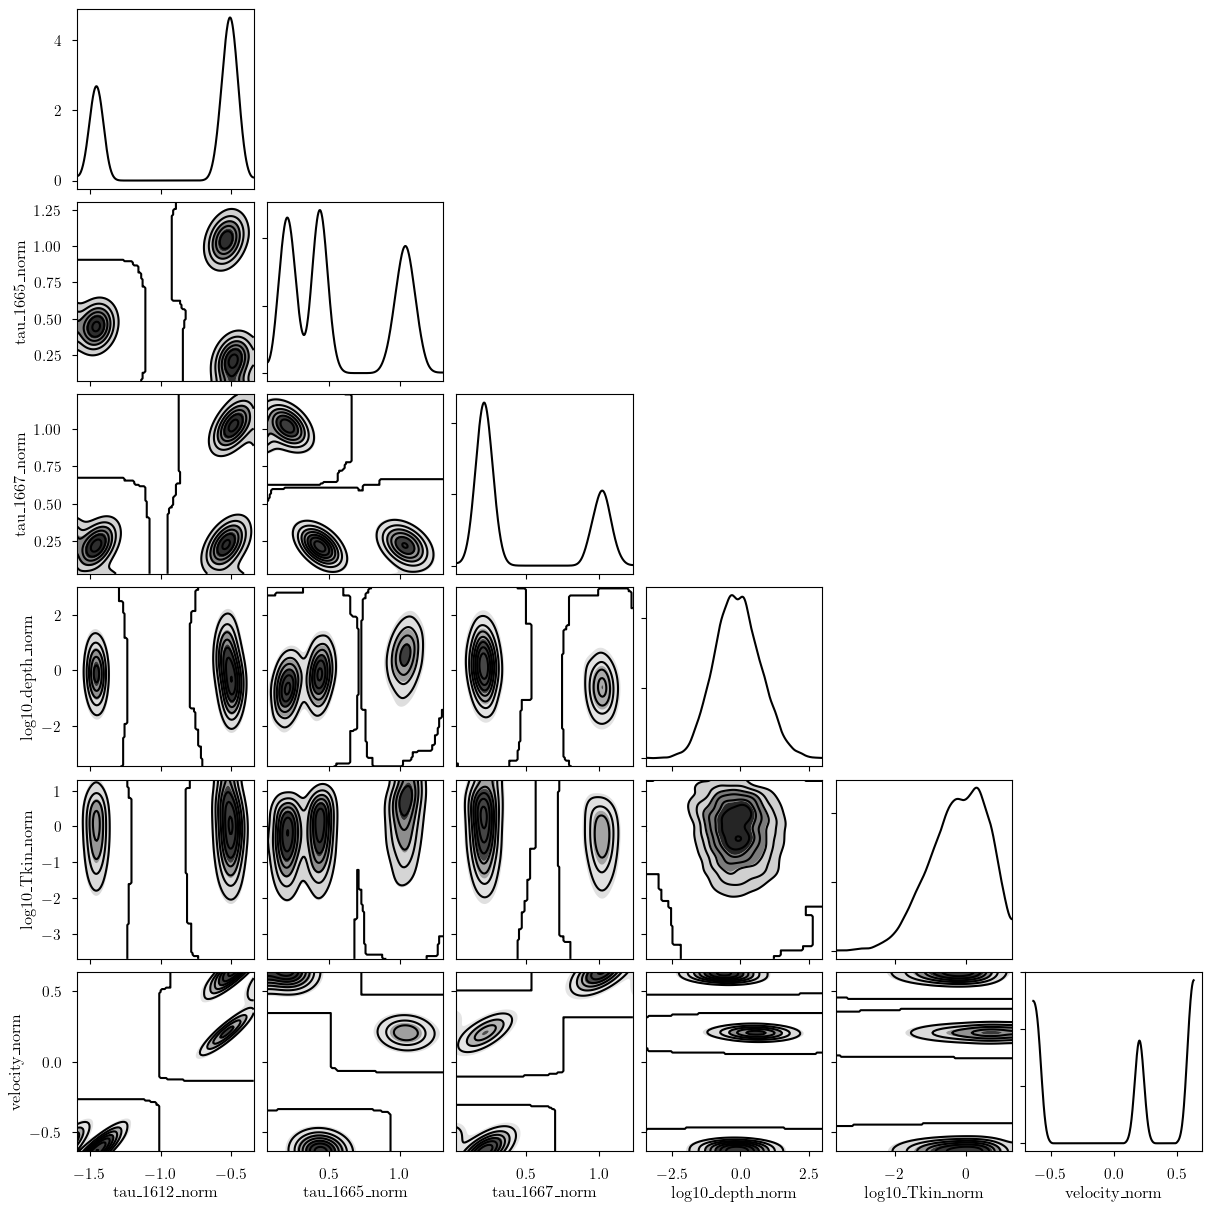

In [19]:
from bayes_spec.plots import plot_pair

axes = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)
axes.ravel()[0].figure.set_size_inches(12, 12)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud.

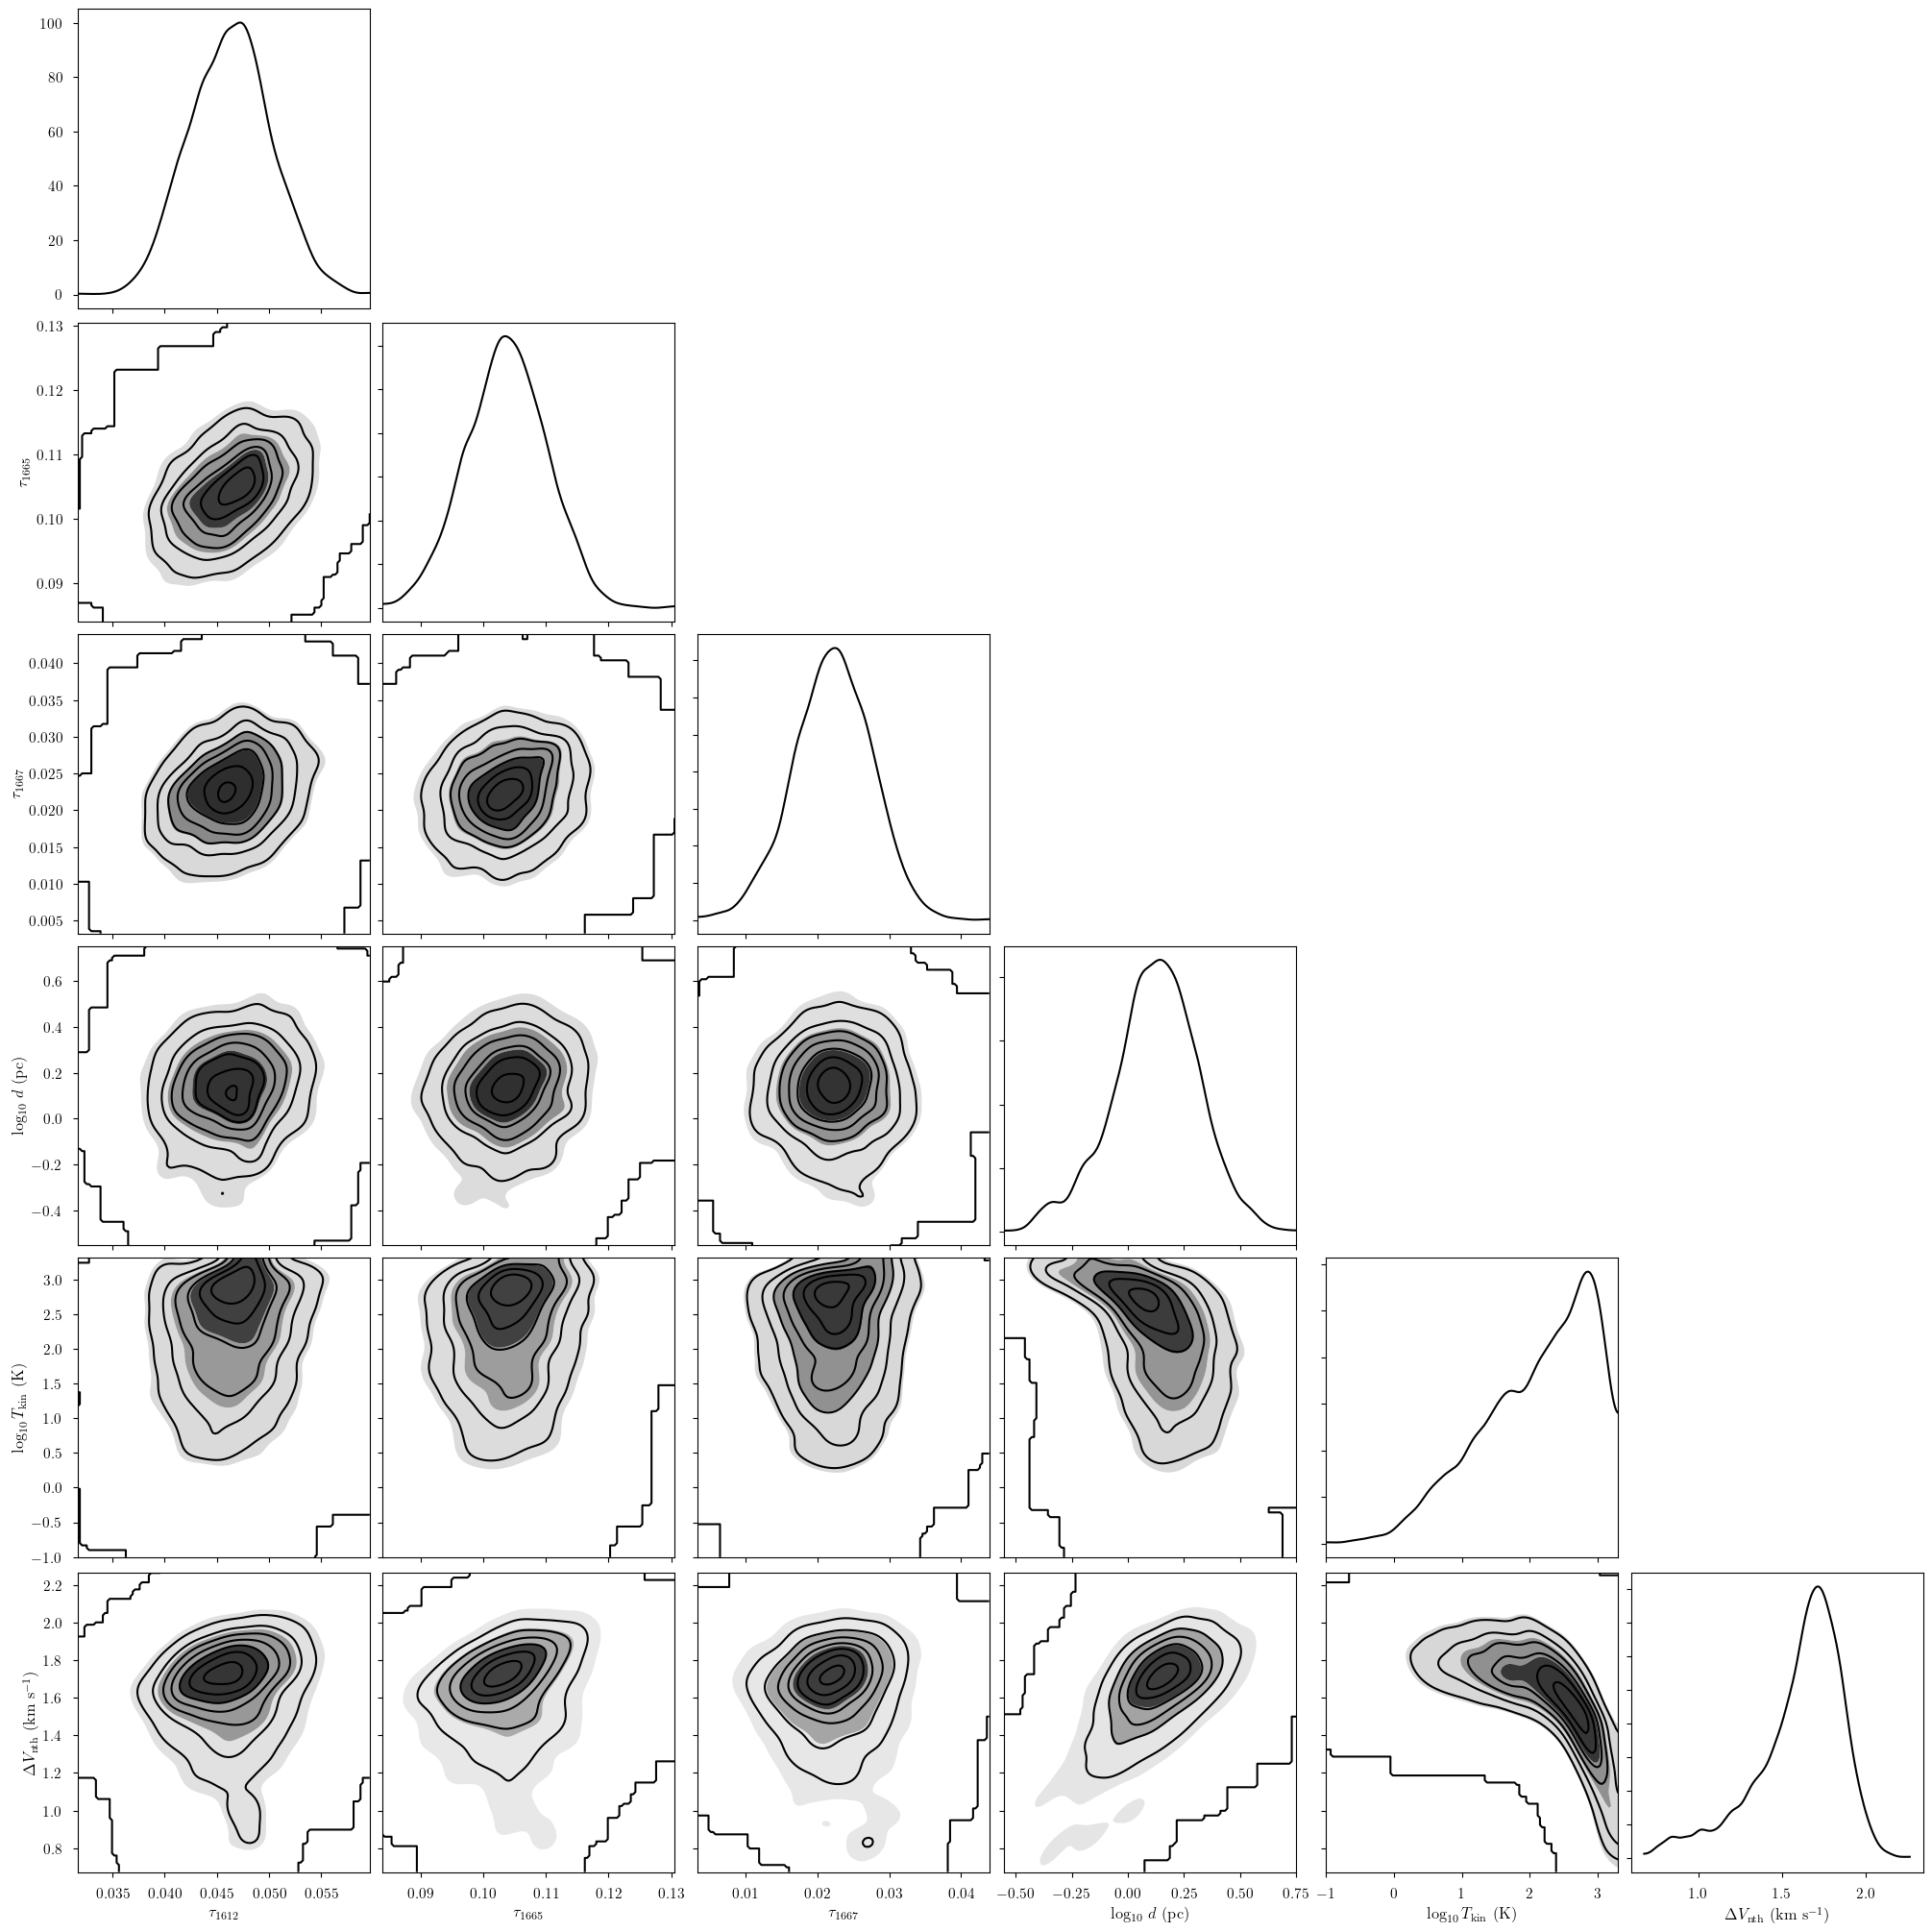

In [20]:
var_names = ["tau_1612", "tau_1665", "tau_1667", "log10_depth", "log10_Tkin", "fwhm_nonthermal"]
axes = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)
axes.ravel()[0].figure.set_size_inches(20, 20)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [21]:
point_stats = az.summary(model.trace.solution_0, kind='stats', stat_focus="median")
print("BIC:", model.bic())
display(point_stats)

"""
tau_params = {
    "tau_1612": np.array([-0.05, 0.05, 0.05]),
    "tau_1665": np.array([0.05, 0.1, 0.02]),
    "tau_1667": np.array([0.02, 0.02, 0.1]),
}
sim_params = {
    "log10_depth": np.array([0.0, 0.25, -0.25]),
    "log10_Tkin": np.array([1.25, 1.75, 1.0]),
    "velocity": np.array([-3.0, 1.0, 3.0]),
    "log10_nth_fwhm_1pc": 0.2,
    "depth_nth_fwhm_power": 0.3,
}
"""

BIC: -11239.35142446794


median    mad  eti_3%  eti_97%
baseline_absorption_1612_norm[0]  -0.093  0.028  -0.168   -0.010
baseline_absorption_1665_norm[0]  -0.311  0.024  -0.377   -0.245
baseline_absorption_1667_norm[0]  -0.250  0.022  -0.315   -0.183
baseline_absorption_1720_norm[0]   0.009  0.024  -0.059    0.076
tau_1612_norm[0]                  -0.537  0.027  -0.609   -0.464
tau_1612_norm[1]                  -1.455  0.024  -1.523   -1.393
tau_1612_norm[2]                  -0.488  0.024  -0.548   -0.418
log10_depth_norm[0]                0.512  0.484  -1.179    1.868
log10_depth_norm[1]               -0.158  0.433  -1.464    1.045
log10_depth_norm[2]               -0.638  0.414  -1.842    0.470
log10_Tkin_norm[0]                 0.257  0.585  -1.636    1.182
log10_Tkin_norm[1]                -0.214  0.559  -1.960    0.815
log10_Tkin_norm[2]                -0.361  0.500  -1.964    0.637
velocity_norm[0]                   0.205  0.007   0.187    0.224
velocity_norm[1]                  -0.606  0.006  -0.623   -0.591
velocity_norm[2]                   0.611  0.004   0.600    0.621
log10_nth_fwhm_1pc_norm           -0.407  0.378  -1.710    0.640
depth_nth_fwhm_power_norm         -0.142  0.692  -1.967    1.742
tau_1665_norm[0]                   1.038  0.043   0.915    1.156
tau_1665_norm[1]                   0.441  0.031   0.358    0.533
tau_1665_norm[2]                   0.211  0.034   0.124    0.303
tau_1667_norm[0]                   0.222  0.037   0.114    0.320
tau_1667_norm[1]                   0.216  0.031   0.136    0.305
tau_1667_norm[2]                   1.017  0.037   0.915    1.123
tau_1612[0]                        0.046  0.003   0.039    0.054
tau_1612[1]                       -0.046  0.002  -0.052   -0.039
tau_1612[2]                        0.051  0.002   0.045    0.058
tau_1665[0]                        0.104  0.004   0.092    0.116
tau_1665[1]                        0.044  0.003   0.036    0.053
tau_1665[2]                        0.021  0.003   0.012    0.030
tau_1667[0]                        0.022  0.004   0.011    0.032
tau_1667[1]                        0.022  0.003   0.014    0.031
tau_1667[2]                        0.102  0.004   0.091    0.112
tau_1720[0]                       -0.023  0.002  -0.030   -0.017
tau_1720[1]                        0.057  0.003   0.050    0.064
tau_1720[2]                       -0.036  0.002  -0.042   -0.030
log10_depth[0]                     0.128  0.121  -0.295    0.467
log10_depth[1]                    -0.040  0.108  -0.366    0.261
log10_depth[2]                    -0.159  0.103  -0.461    0.117
log10_Tkin[0]                      2.257  0.585   0.364    3.182
log10_Tkin[1]                      1.786  0.559   0.040    2.815
log10_Tkin[2]                      1.639  0.500   0.036    2.637
velocity[0]                        1.025  0.034   0.936    1.120
velocity[1]                       -3.032  0.030  -3.114   -2.955
velocity[2]                        3.055  0.019   3.000    3.106
log10_nth_fwhm_1pc                 0.159  0.038   0.029    0.264
depth_nth_fwhm_power               0.386  0.069   0.203    0.574
fwhm_thermal[0]                    0.564  0.362   0.064    1.636
fwhm_thermal[1]                    0.328  0.198   0.044    1.073
fwhm_thermal[2]                    0.277  0.150   0.044    0.873
fwhm_nonthermal[0]                 1.659  0.146   0.930    1.972
fwhm_nonthermal[1]                 1.404  0.090   1.040    1.637
fwhm_nonthermal[2]                 1.268  0.064   0.936    1.428
fwhm[0]                            1.807  0.084   1.597    2.061
fwhm[1]                            1.477  0.071   1.291    1.681
fwhm[2]                            1.317  0.050   1.185    1.458

'\ntau_params = {\n    "tau_1612": np.array([-0.05, 0.05, 0.05]),\n    "tau_1665": np.array([0.05, 0.1, 0.02]),\n    "tau_1667": np.array([0.02, 0.02, 0.1]),\n}\nsim_params = {\n    "log10_depth": np.array([0.0, 0.25, -0.25]),\n    "log10_Tkin": np.array([1.25, 1.75, 1.0]),\n    "velocity": np.array([-3.0, 1.0, 3.0]),\n    "log10_nth_fwhm_1pc": 0.2,\n    "depth_nth_fwhm_power": 0.3,\n}\n'

## Visualization using Mean Point Estimate

Here we demonstrate how to visualize the contribution of individual cloud components on the data from the mean posterior point estimates. Inspecting `predict_tau` in the model definition reveals how this works. Note that the mean posterior point estimate might not always be located within the posterior distribution (especially if there are strong parameter correlations)!

In [22]:
# extract parameter mean point estimates
mean_point = model.trace.solution_0.mean(dim=["chain", "draw"])
mean_point

<xarray.Dataset> Size: 480B
Dimensions:                        (baseline_coeff: 1, cloud: 3)
Coordinates:
  * baseline_coeff                 (baseline_coeff) int64 8B 0
  * cloud                          (cloud) int64 24B 0 1 2
Data variables: (12/24)
    baseline_absorption_1612_norm  (baseline_coeff) float64 8B -0.09223
    baseline_absorption_1665_norm  (baseline_coeff) float64 8B -0.3111
    baseline_absorption_1667_norm  (baseline_coeff) float64 8B -0.2504
    baseline_absorption_1720_norm  (baseline_coeff) float64 8B 0.009297
    tau_1612_norm                  (cloud) float64 24B -0.5374 -1.456 -0.4864
    log10_depth_norm               (cloud) float64 24B 0.4783 -0.1653 -0.6478
    ...                             ...
    velocity                       (cloud) float64 24B 1.026 -3.033 3.055
    log10_nth_fwhm_1pc             float64 8B 0.1551
    depth_nth_fwhm_power           float64 8B 0.3865
    fwhm_thermal                   (cloud) float64 24B 0.6637 0.4094 0.3356
    fwhm_nonthermal                (cloud) float64 24B 1.602 1.387 1.249
    fwhm                           (cloud) float64 24B 1.813 1.481 1.318

In [23]:
from amoeba2 import physics

# evaluate line profile
line_profile = {}
for label in model.model.coords["transition"]:
    line_profile[label] = physics.calc_line_profile(
        model.data[f"absorption_{label}"].spectral,
        mean_point["velocity"].data,
        mean_point["fwhm"].data,
    ).eval()

# shape: spectral, clouds
print(line_profile["1612"].shape)

(400, 3)


In [24]:
# evaluate optical depth
tau = {}
for i, label in enumerate(model.model.coords["transition"]):
    tau[label] = mean_point[f"tau_{label}"].data * line_profile[label]
    
# shape: spectral, clouds
print(tau["1612"].shape)

(400, 3)


In [25]:
# evaluate un-normalized baseline
baseline = {}
for i, label in enumerate(model.model.coords["transition"]):
    baseline_norm = np.sum([
        mean_point[f"baseline_absorption_{label}_norm"].data[j] / (j + 1.0)**j
        * model.data[f"absorption_{label}"].spectral_norm**j
        for j in range(model.baseline_degree + 1)
    ], axis=0)
    baseline[label] = model.data[f"absorption_{label}"].unnormalize_brightness(baseline_norm)
    
# shape: spectral
print(baseline['1612'].shape)

(400,)


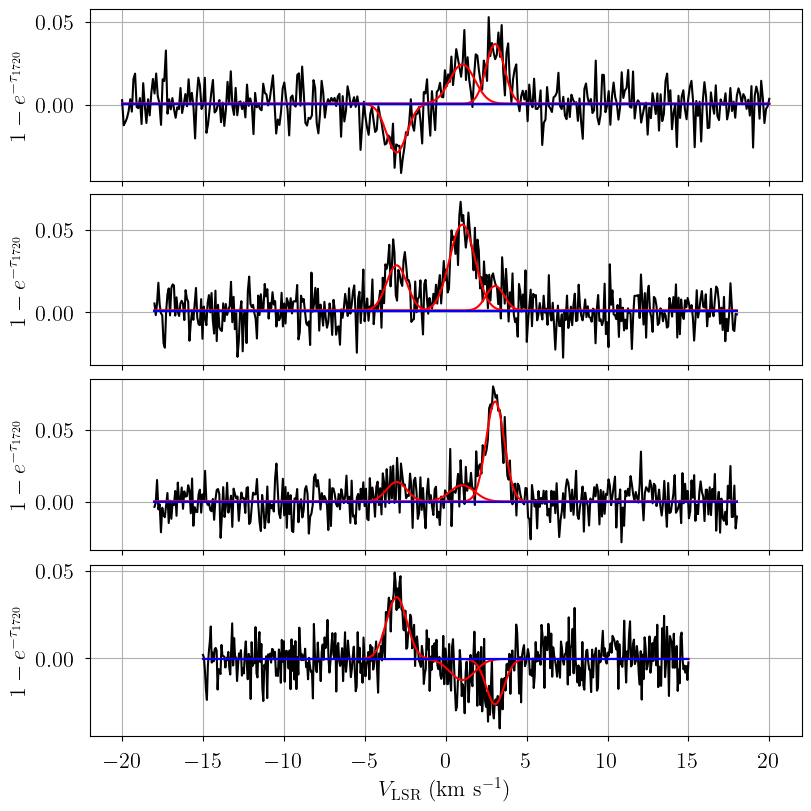

In [26]:
# Plot cloud contributions over data
fig, axes = plt.subplots(4, sharex=True, layout="constrained", figsize=(8, 8))
for i, label in enumerate(model.model.coords["transition"]):
    axes[i].plot(model.data[f"absorption_{label}"].spectral, model.data[f"absorption_{label}"].brightness, "k-")
    for j in range(n_clouds):
        axes[i].plot(model.data[f"absorption_{label}"].spectral, 1.0 - np.exp(-tau[label][:, j]) + baseline[label], 'r-')
    # baseline
    axes[i].plot(model.data[f"absorption_{label}"].spectral, baseline[label], 'b-')
    axes[i].set_ylabel(datum.ylabel)
_ = axes[-1].set_xlabel(datum.xlabel)